# Import libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import datetime
import matplotlib.pyplot as plt
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from keras import initializers
from keras import metrics
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package
import xgboost as xgb
import numpy as np
import talib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

# Traffic data

In [3]:
train = pd.read_csv('train.csv')
EB00=train[(train['x']==0) & (train['y']==0) & (train['direction']=='EB')].loc[:,['time','congestion']]

In [4]:
train

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17


In [5]:
EB00['time']=pd.to_datetime(EB00['time'])
EB00.set_index('time',inplace=True)

In [6]:
EB00

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-09-30 10:20:00,43
1991-09-30 10:40:00,47
1991-09-30 11:00:00,40


In [7]:
train_size = int(len(EB00) * 0.8)
EB00_train=pd.DataFrame(EB00.iloc[:train_size,0])
EB00_test=pd.DataFrame(EB00.iloc[train_size:,0])

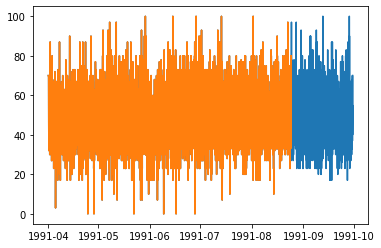

In [8]:
plt.plot(EB00)
plt.plot(EB00_train)

In [21]:
EB00_train_T=EB00_train.T
EB00_train_noisy = pd.DataFrame(np.repeat(EB00_train_T.values,100,axis=0), columns=EB00_train_T.columns)

EB00_train_noisy=EB00_train_noisy.iloc[:,51:]
EB00_train_noisy

time,1991-04-01 17:00:00,1991-04-01 17:20:00,1991-04-01 17:40:00,1991-04-01 18:00:00,1991-04-01 18:20:00,1991-04-01 18:40:00,1991-04-01 19:00:00,1991-04-01 19:20:00,1991-04-01 19:40:00,1991-04-01 20:00:00,...,1991-08-24 09:20:00,1991-08-24 09:40:00,1991-08-24 10:00:00,1991-08-24 10:20:00,1991-08-24 10:40:00,1991-08-24 11:00:00,1991-08-24 11:20:00,1991-08-24 11:40:00,1991-08-24 12:00:00,1991-08-24 12:20:00
0,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
1,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
2,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
3,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
4,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
96,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
97,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43
98,63,57,40,42,50,42,45,57,45,53,...,37,80,70,38,57,68,48,80,50,43


In [22]:
EB00_train_T

time,1991-04-01 00:00:00,1991-04-01 00:20:00,1991-04-01 00:40:00,1991-04-01 01:00:00,1991-04-01 01:20:00,1991-04-01 01:40:00,1991-04-01 02:00:00,1991-04-01 02:20:00,1991-04-01 02:40:00,1991-04-01 03:00:00,...,1991-08-24 09:20:00,1991-08-24 09:40:00,1991-08-24 10:00:00,1991-08-24 10:20:00,1991-08-24 10:40:00,1991-08-24 11:00:00,1991-08-24 11:20:00,1991-08-24 11:40:00,1991-08-24 12:00:00,1991-08-24 12:20:00
congestion,70,70,70,70,70,70,70,70,70,70,...,37,80,70,38,57,68,48,80,50,43


In [23]:
EB00_train_pure=pd.DataFrame(columns=EB00_train_T.columns)
for window in range(2,52):#SMA and EMA 
    rolling_mean = talib.SMA(EB00_train['congestion'],timeperiod=window)
    EB00_train_pure=pd.concat([EB00_train_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  talib.EMA(EB00_train['congestion'],timeperiod=window)
    EB00_train_pure=pd.concat([EB00_train_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
EB00_train_pure=EB00_train_pure.iloc[:,51:]#.shift(periods=1, freq=None, axis=1)
EB00_train_pure

time,1991-04-01 17:00:00,1991-04-01 17:20:00,1991-04-01 17:40:00,1991-04-01 18:00:00,1991-04-01 18:20:00,1991-04-01 18:40:00,1991-04-01 19:00:00,1991-04-01 19:20:00,1991-04-01 19:40:00,1991-04-01 20:00:00,...,1991-08-24 09:20:00,1991-08-24 09:40:00,1991-08-24 10:00:00,1991-08-24 10:20:00,1991-08-24 10:40:00,1991-08-24 11:00:00,1991-08-24 11:20:00,1991-08-24 11:40:00,1991-08-24 12:00:00,1991-08-24 12:20:00
0,53.0,60.0,48.5,41.0,46.0,46.0,43.5,51.0,51.0,49.0,...,35.0,58.5,75.0,54.0,47.5,62.5,58.0,64.0,65.0,46.5
1,55.333333,54.333333,53.333333,46.333333,44.0,44.666667,45.666667,48.0,49.0,51.666667,...,40.0,50.0,62.333333,62.666667,55.0,54.333333,57.666667,65.333333,59.333333,57.666667
2,52.25,55.75,50.75,50.5,47.25,43.5,44.75,48.5,47.25,50.0,...,39.25,50.0,55.0,56.25,61.25,58.25,52.75,63.25,61.5,55.25
3,51.8,53.2,52.6,49.0,50.4,46.2,43.8,47.2,47.8,48.4,...,41.4,47.4,54.0,51.6,56.4,62.6,56.2,58.2,60.6,57.8
4,51.833333,52.666667,51.0,50.833333,49.166667,49.0,46.0,46.0,46.833333,48.666667,...,42.833333,47.833333,51.166667,51.333333,52.5,58.333333,60.166667,60.166667,56.833333,57.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,54.326521,54.437916,53.836336,53.343156,53.203858,52.73703,52.414654,52.60571,52.288805,52.318439,...,45.28644,46.732838,47.702303,47.29804,47.702289,48.548027,48.525192,49.836643,49.843449,49.558305
96,54.418272,54.523649,53.930847,53.443873,53.303307,52.841948,52.521868,52.704649,52.390174,52.415064,...,45.347074,46.76148,47.709991,47.313664,47.709025,48.537228,48.5153,49.80039,49.808538,49.530638
97,54.628236,54.723106,54.134182,53.648815,53.502862,53.042748,52.721038,52.892196,52.576508,52.593448,...,45.406694,46.790426,47.718809,47.330057,47.716855,48.528181,48.507053,49.766771,49.7761,49.505056
98,54.529273,54.626165,54.05259,53.579939,53.439549,52.990939,52.677569,52.847076,52.539348,52.557413,...,45.465293,46.819595,47.72863,47.347116,47.72566,48.520732,48.500311,49.735593,49.745962,49.481415


## Fit models(ltsm/cnn)

## MinMaxScaler(GSPC)

In [24]:
mm_t = MinMaxScaler()
noise_mm = mm_t.fit_transform(EB00_train_noisy.T).T
pure_mm=mm_t.fit_transform(EB00_train_pure.T).T
print(noise_mm.shape)
print(pure_mm.shape)

(100, 10396)
(100, 10396)


In [25]:
train_pure_mm=np.reshape(pure_mm,(len(pure_mm), len(pure_mm[0]), 1))
train_mm=np.reshape(noise_mm, (len(noise_mm), len(noise_mm[0]), 1))

# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_pure_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

## CNN

In [122]:
keras.backend.clear_session()

In [139]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=4, activation='elu', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=4,activation='elu',padding='same'))
    model.add(Conv1D(64, kernel_size=4, activation='elu', padding='same'))
    model.add(Conv1D(128, kernel_size=4,activation='elu',padding='same'))
    model.add(Conv1D(1,kernel_size=4,activation='relu', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mse'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 128)         640       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          32832     
                                                                 
 conv1d_7 (Conv1D)           (None, None, 64)          16448     
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         32896     
                                                                 
 conv1d_9 (Conv1D)           (None, None, 1)           513       
                                                                 
Total params: 83,329
Trainable params: 83,329
Non-trainable params: 0
_________________________________________________________________


In [140]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
3/3 [==============================] - 3s 876ms/step - loss: 0.1357 - mse: 0.1357 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 2/400
3/3 [==============================] - 3s 832ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/400
3/3 [==============================] - 3s 835ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 4/400
3/3 [==============================] - 3s 836ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 5/400
3/3 [==============================] - 3s 836ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 6/400
3/3 [==============================] - 3s 939ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 7/400
3/3 [==============================] - 3s 920ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 8/400
3/3 [==============================] - 3s 923ms/step - loss: 0.0122 - m

In [99]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

In [100]:
modelen_mm.load_weights('model_weights_mm.h5') 

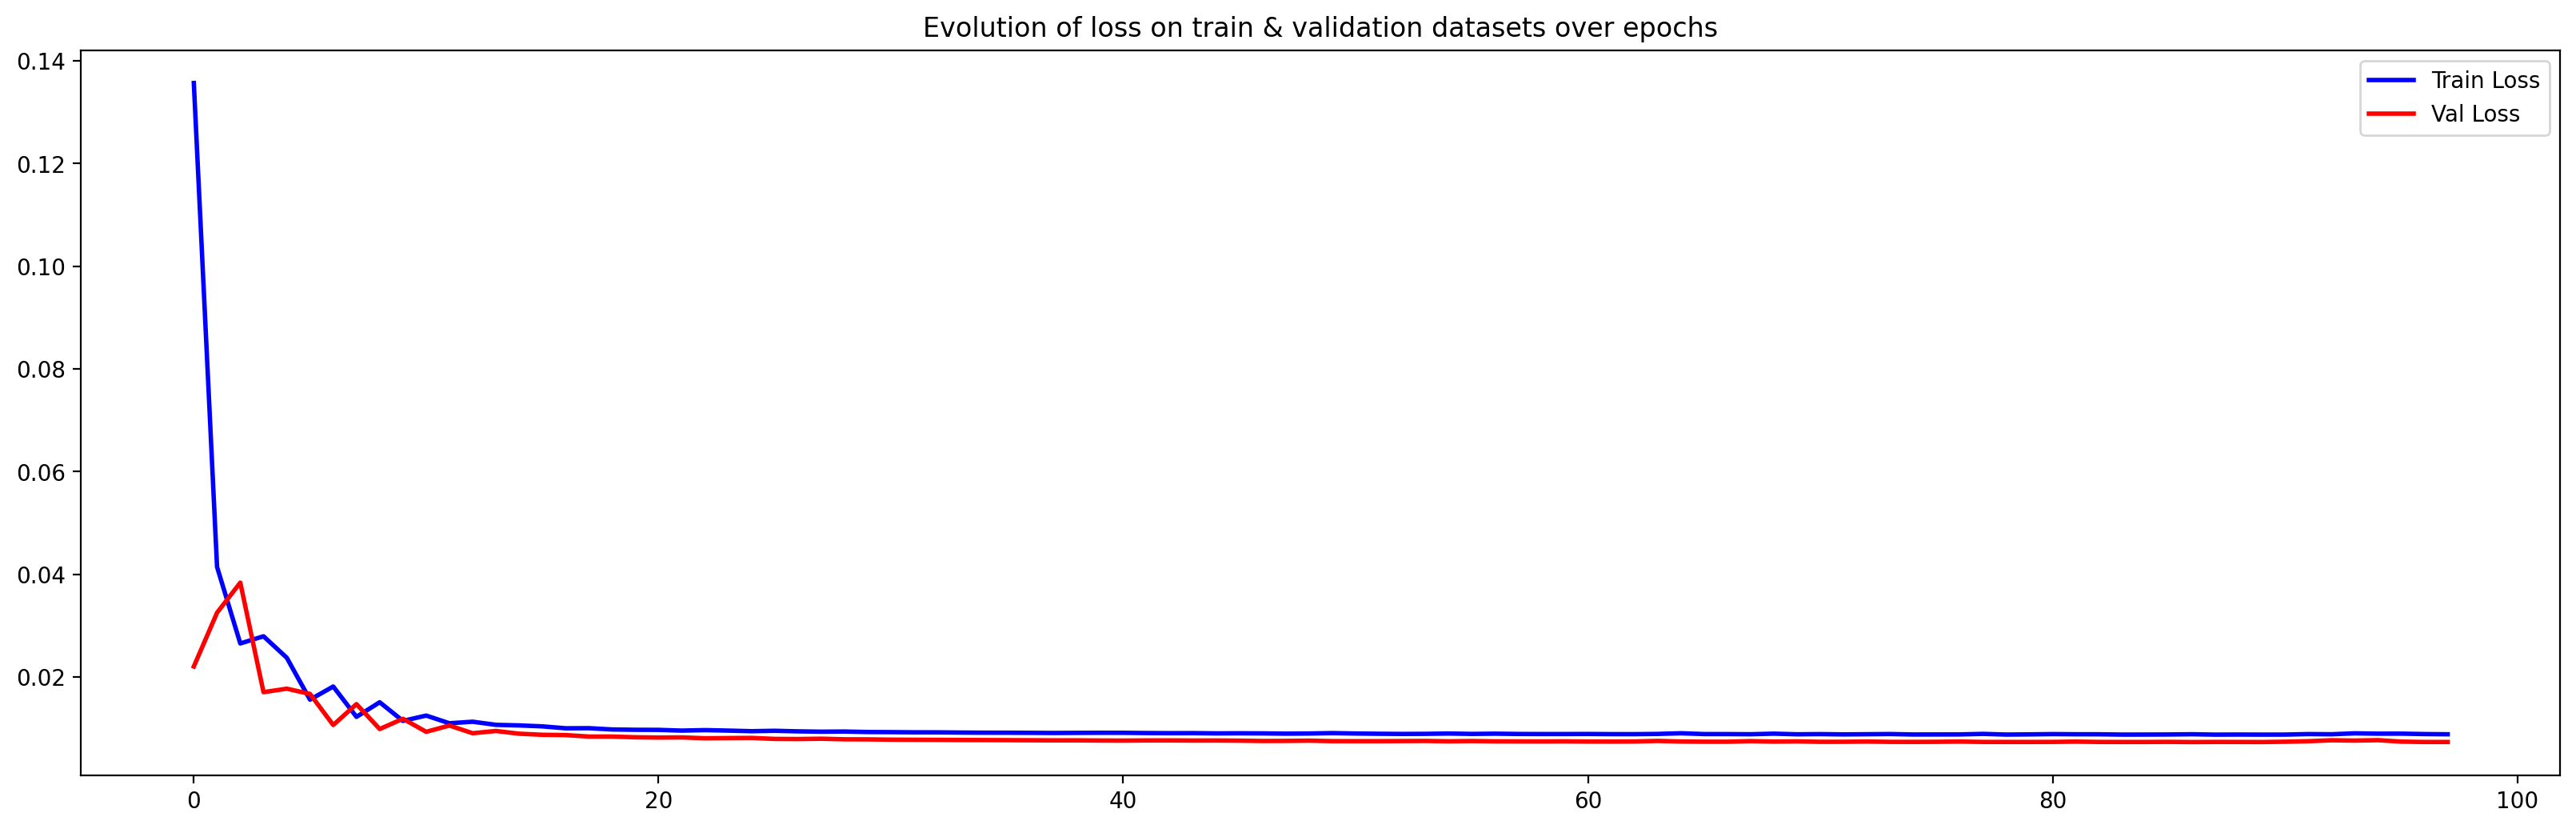

In [141]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mse = history_mm.history['mse']
epoch_val_mse = history_mm.history['val_mse']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [39]:
EB00_test.shape

(4441, 1)

1/1 [==============================] - 0s 74ms/step


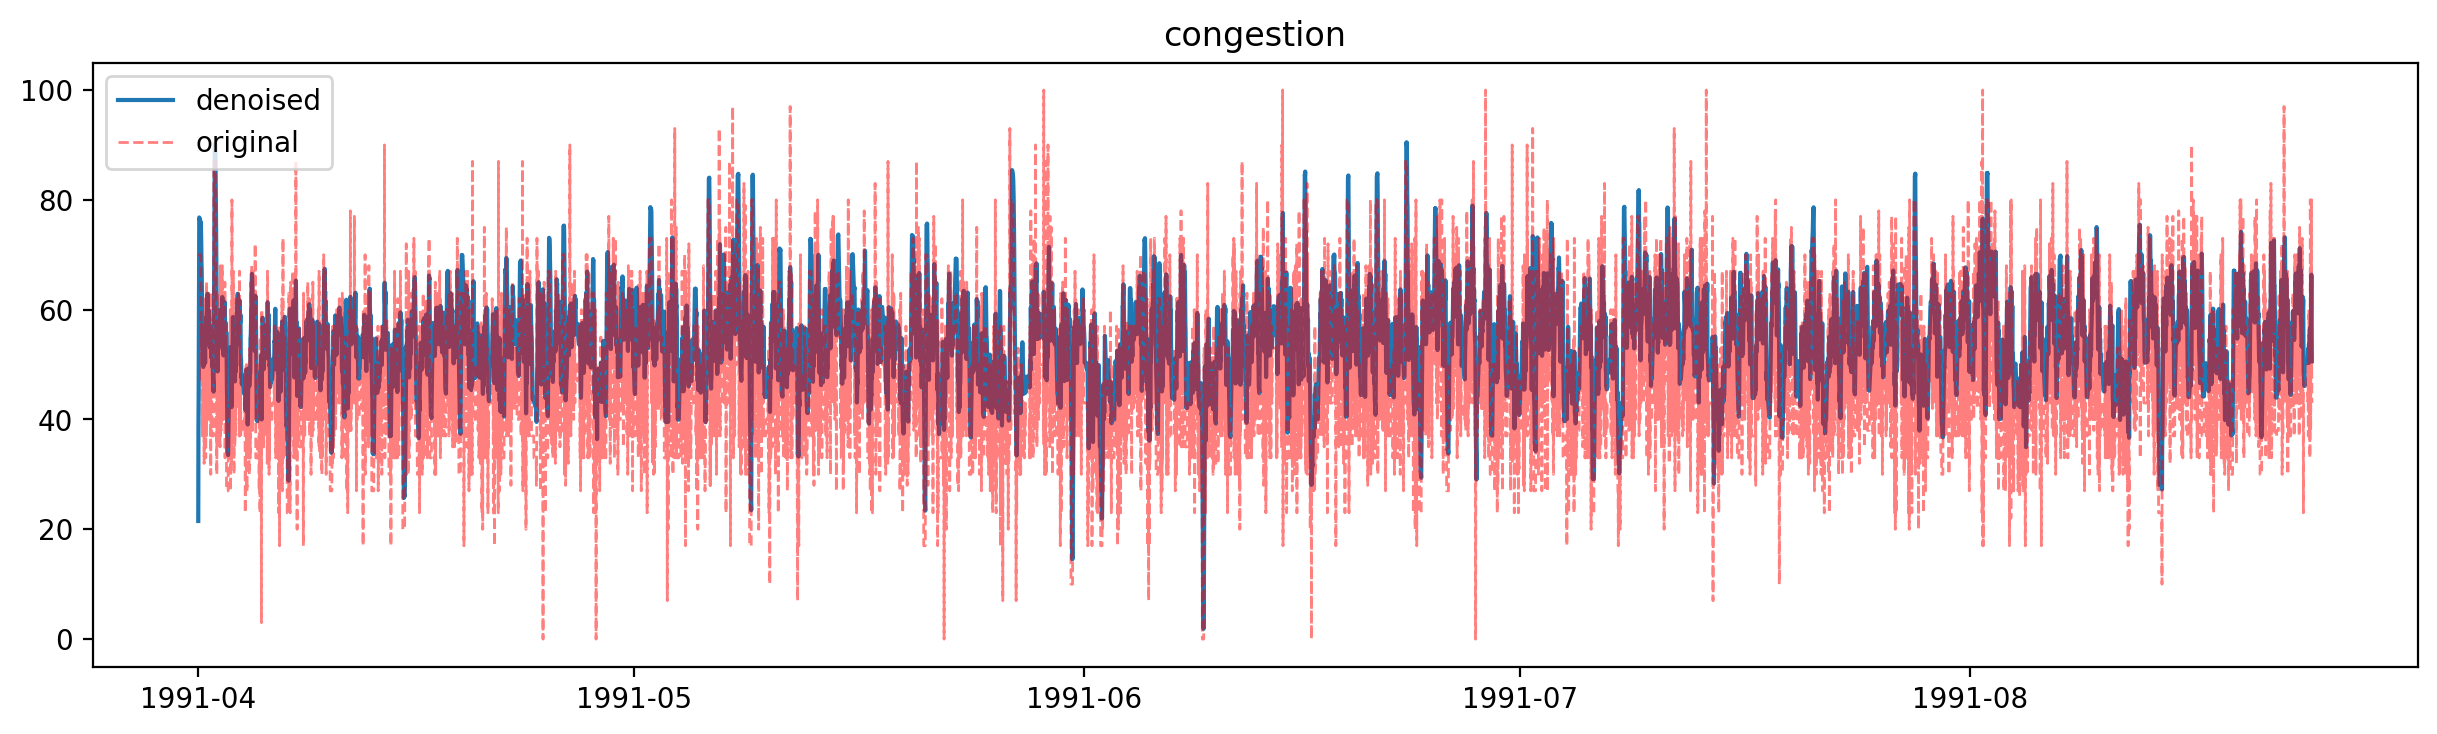

In [142]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(EB00_train)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(EB00_train),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['congestion'],index=EB00_train.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(EB00_train,color='r',linestyle='--',linewidth=1,alpha=0.5)
plt.title('congestion')
plt.legend(['denoised', 'original'], loc='upper left')

In [143]:
original=EB00_train

1/1 [==============================] - 0s 68ms/step


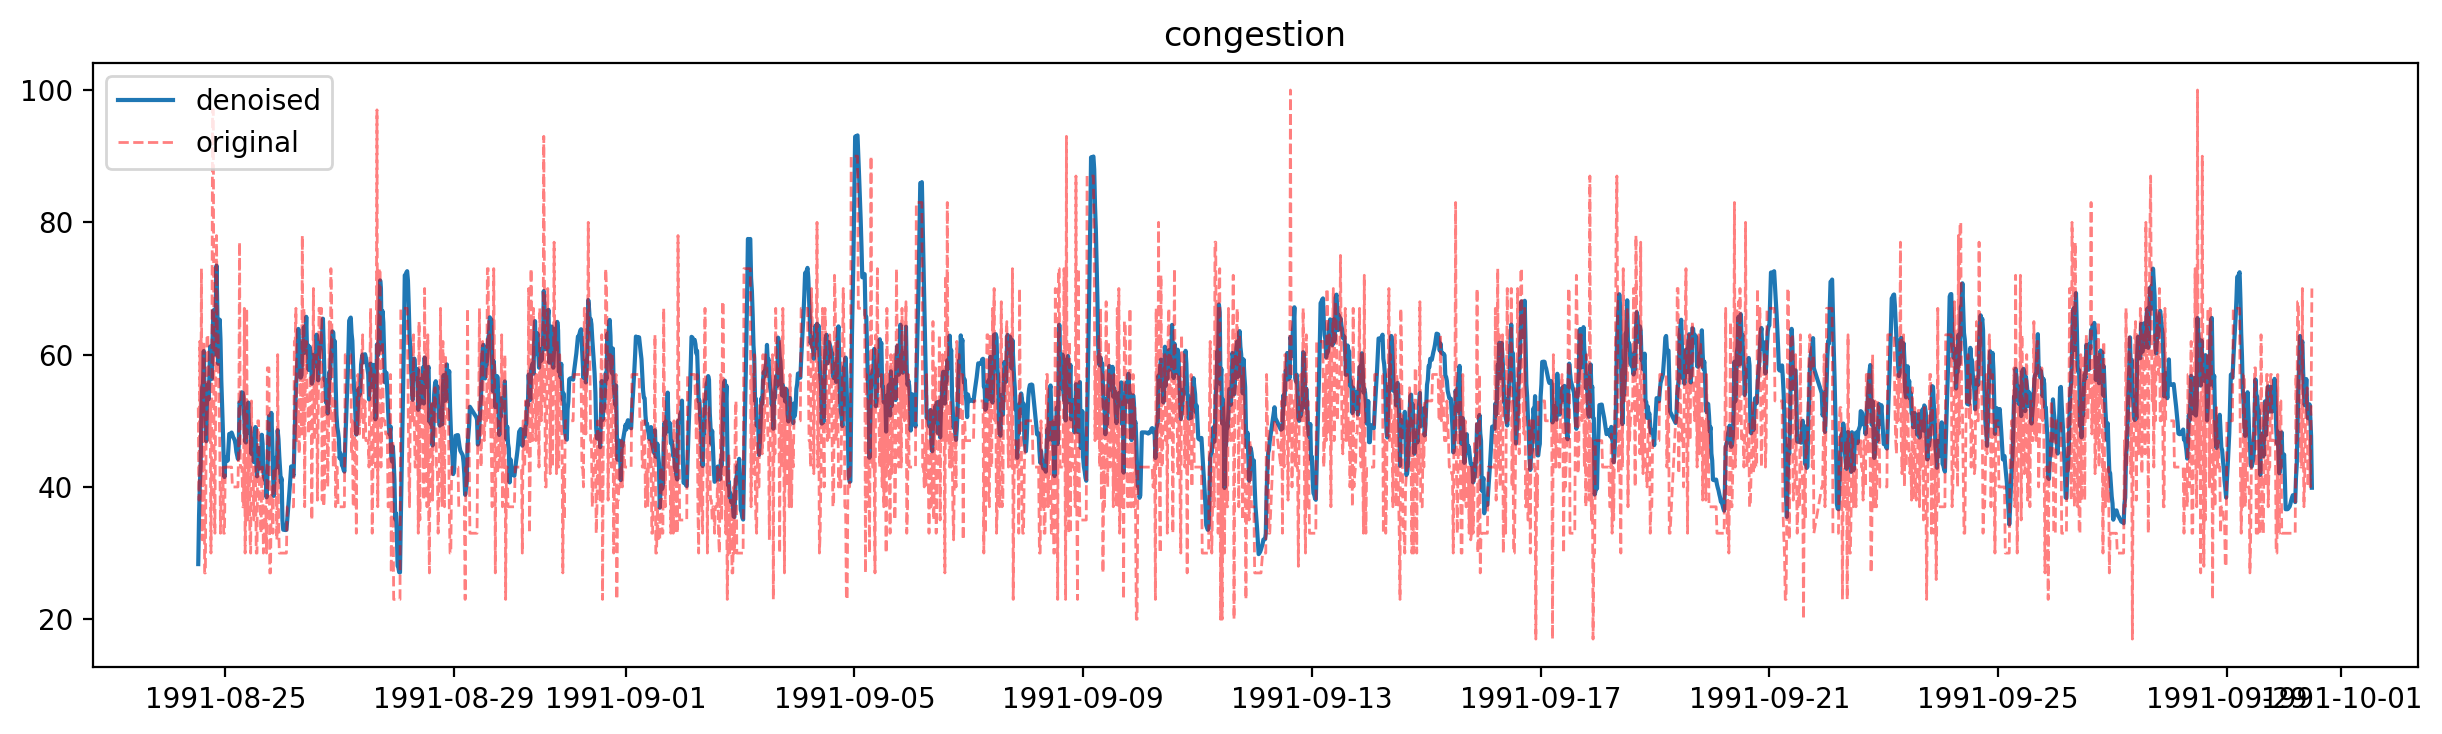

In [147]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(EB00_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(EB00_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['congestion'],index=EB00_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(EB00_test,color='r',linestyle='--',linewidth=1,alpha=0.5)
plt.title('congestion')
plt.legend(['denoised', 'original'], loc='upper left')

In [148]:
original=EB00_test

In [128]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['congestion'].shift(i)
    return ret_dataset

In [129]:
from sklearn.model_selection import TimeSeriesSplit

In [130]:
splits=5

In [144]:
pure_mm_cnn_fea=features(pure_mm_cnn)
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
original_m=original.iloc[51::]
pure_mm_cnn_m=pure_mm_cnn.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(pure_mm_cnn_fea):
    model = xgb.XGBRegressor()
    model.fit(pure_mm_cnn_fea.iloc[train_index,:],pure_mm_cnn_m.iloc[train_index,:])
    test_predict=model.predict(pure_mm_cnn_fea.iloc[test_index,:])
    msetest=mean_squared_error(pure_mm_cnn_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

9.440037536621094

In [145]:
pure_mm_cnn_fea=features(pure_mm_cnn)
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
original_m=original.iloc[51::]
pure_mm_cnn_m=pure_mm_cnn.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(pure_mm_cnn_fea):
    model = xgb.XGBRegressor()
    model.fit(pure_mm_cnn_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(pure_mm_cnn_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

160.06450454175754

In [146]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

147.62879062077891

In [149]:
pure_mm_cnn_fea=features(pure_mm_cnn)
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
original_m=original.iloc[51::]
pure_mm_cnn_m=pure_mm_cnn.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(pure_mm_cnn_fea):
    model = xgb.XGBRegressor()
    model.fit(pure_mm_cnn_fea.iloc[train_index,:],pure_mm_cnn_m.iloc[train_index,:])
    test_predict=model.predict(pure_mm_cnn_fea.iloc[test_index,:])
    msetest=mean_squared_error(pure_mm_cnn_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

16.1788688659668

In [150]:
pure_mm_cnn_fea=features(pure_mm_cnn)
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
original_m=original.iloc[51::]
pure_mm_cnn_m=pure_mm_cnn.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(pure_mm_cnn_fea):
    model = xgb.XGBRegressor()
    model.fit(pure_mm_cnn_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(pure_mm_cnn_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

182.1216892604239

In [151]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

169.52712242140979

In [108]:
pure_mm_cnn_fea=features(pure_mm_cnn)
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(pure_mm_cnn_fea, original.iloc[51:], test_size=0.2,shuffle=False)

model = xgb.XGBRegressor()
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

print(msetest)
print(msetrain)

145.9826221743194
20.722789942637537


In [72]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(original_fea, original.iloc[51:], test_size=0.2)

model = xgb.XGBRegressor()
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

print(msetest)
print(msetrain)

130.8151111803582
0.7846040418450801


In [124]:
pure_mm_cnn_whole=pure_mm_cnn_fea.copy()
pure_mm_cnn_whole['target']=original.iloc[51:]

In [127]:
pure_mm_cnn_whole.to_csv('pure_mm_cnn_whole.csv')

In [128]:
original_whole=original_fea.copy()
original_whole['target']=original.iloc[51:]
original_whole.to_csv('original_whole.csv')

In [121]:
original_fea.to_csv('original_fea.csv')
pure_mm_cnn_fea.to_csv('pure_mm_cnn_fea.csv')
original.to_csv('original.csv')

In [ ]:
max_depth=5,
learning_rate=0.1,
n_estimators=100,
gamma=0,
min_child_weight=1,
subsample=0.8,
colsample_bytree=0.8,
colsample_bylevel=1,
reg_alpha=0,
reg_lambda=1